In [1]:
import os
import numpy as np
import nibabel as nib
from PIL import Image
import SimpleITK as sitk
from typing import List
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits import mplot3d

%matplotlib inline

In [2]:
def subdirs(folder: str, join: bool = True, prefix: str = None, suffix: str = None, sort: bool = True) -> List[str]:
    if join:
        l = os.path.join
    else:
        l = lambda x, y: y
    res = [l(folder, i) for i in os.listdir(folder) if os.path.isdir(os.path.join(folder, i))
           and (prefix is None or i.startswith(prefix))
           and (suffix is None or i.endswith(suffix))]
    if sort:
        res.sort()
    return res

def subfiles(folder: str, join: bool = True, prefix: str = None, suffix: str = None, sort: bool = True) -> List[str]:
    if join:
        l = os.path.join
    else:
        l = lambda x, y: y
    res = [l(folder, i) for i in os.listdir(folder) if os.path.isfile(os.path.join(folder, i))
           and (prefix is None or i.startswith(prefix))
           and (suffix is None or i.endswith(suffix))]
    if sort:
        res.sort()
    return res

def maybe_mkdir_p(directory: str) -> None:
    os.makedirs(directory, exist_ok=True)
    
# os.listdir('/tf/submission/submitted/21-11-04_13:18:26-models/result/3d_fullres/')

In [3]:
model_NUM = '21-11-22_23:41:56-models'
PN_list = subfiles('/tf/submission/submitted/{}/result/'.format(model_NUM), join=False, suffix='nii.gz')
PN_list_path = subfiles('/tf/submission/submitted/{}/result/'.format(model_NUM), join=True, suffix='nii.gz')
PN = PN_list[36][:17] # removed suffix
print(PN)

ptarr = np.array(nib.load('/tf/submission/submitted/{}/temp/convert_data/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task301_PETCT/imagesTs/{}_0001.nii.gz'.format(model_NUM, PN)).dataobj)
ctarr = np.array(nib.load('/tf/submission/submitted/{}/temp/convert_data/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task301_PETCT/imagesTs/{}_0000.nii.gz'.format(model_NUM, PN)).dataobj)
pred_arr = np.array(nib.load(PN_list_path[36]).dataobj)

size = ([4.6875, 4.6875, 3.27001953]) # [4.6875, 4.6875, 3.27001953]


23170035_20180813


In [33]:
#Calculate Mean SUV and Max SUV
def get_suv_params(ptarr, roi):
    roi = np.asarray(roi>0, dtype=np.float)
    suvmax = np.max(ptarr*roi)
    suvmean = np.sum(ptarr*roi)/np.sum(roi)
    return suvmax, suvmean

suvmax, suvmean = get_suv_params(ptarr, pred_arr)
print('2d suvmax :', suvmax, ', suvmean :', suvmean)


#Calculate Volume
def get_vol_params(ptzoom, roi):
    roi = np.asarray(roi>0, dtype=np.float)
    return np.prod(ptzoom) * np.sum(roi)

aorvol = get_vol_params(size, pred_arr)
print('\n2d volume :', aorvol)


2d suvmax : 2.6091420017030384 , suvmean : 1.633217046780628

2d volume : 81335.34905185548


In [34]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_pred - y_test) / y_test))*100

MAPE_suvmean = MAPE(suvmean, suvmean)
MAPE_vol = MAPE(aorvol, aorvol)

# print('MAPEs : %.3f and %.3f'%(MAPE_suvmean, MAPE_vol))
print(f'MAPEs : {MAPE_suvmean} and {MAPE_vol}')
print(f'Final Accuracy : {(MAPE_suvmean + MAPE_vol)/2}')

MAPEs : 0.0 and 0.0
Final Accuracy : 0.0


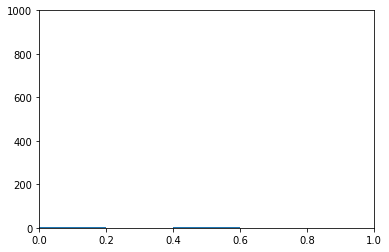

In [247]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(nn, bins=5)
# plt.histogramdd(ptarr)
plt.axis([0, 1, 0, 1000])
plt.show()

In [34]:
%matplotlib inline

In [5]:
def check_petctroi(ptarr_,ctarr_,roi):
    zind = int(np.median(np.where(roi)[2]))
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.imshow(ctarr_[:,:,zind], cmap='gray', vmin=-150, vmax=250)
    plt.imshow(ptarr_[:,:,zind],cmap='hot', alpha=0.3)
    plt.imshow(roi[:,:,zind], alpha=0.6, cmap='Greens')
    plt.axis('off')
    
    xind = int(np.median(np.where(roi)[0]))
    plt.subplot(1,3,2)    
    plt.imshow(np.rot90(ctarr_[xind,:,:]), cmap='gray', vmin=-150, vmax=250)
    plt.imshow(np.rot90(ptarr_[xind,:,:]),alpha=0.3, cmap='hot')
    plt.imshow(np.rot90(roi[xind,:,:]), alpha=0.6, cmap='Greens')
    plt.axis('off')
    
    yind = int(np.median(np.where(roi)[1]))
    plt.subplot(1,3,3)    
    plt.imshow(np.rot90(ctarr_[:,yind,:]), cmap='gray', vmin=-150, vmax=250)
    plt.imshow(np.rot90(ptarr_[:,yind,:]),alpha=0.3, cmap='hot')
    plt.imshow(np.rot90(roi[:,yind,:]), alpha=0.6, cmap='Greens')
    plt.axis('off')
    
    plt.show()

In [43]:
def view_3d(path_NUM:int):
    pred_arr = np.array(nib.load(PN_list_path[path_NUM]).dataobj)
    
    plt.figure(figsize=(18,18))
    plt.title(model_NUM + PN_list[path_NUM])
    ax = plt.axes(projection='3d')
    ax.voxels(pred_arr)
    # ax.axis('off')
    
    plt.show()

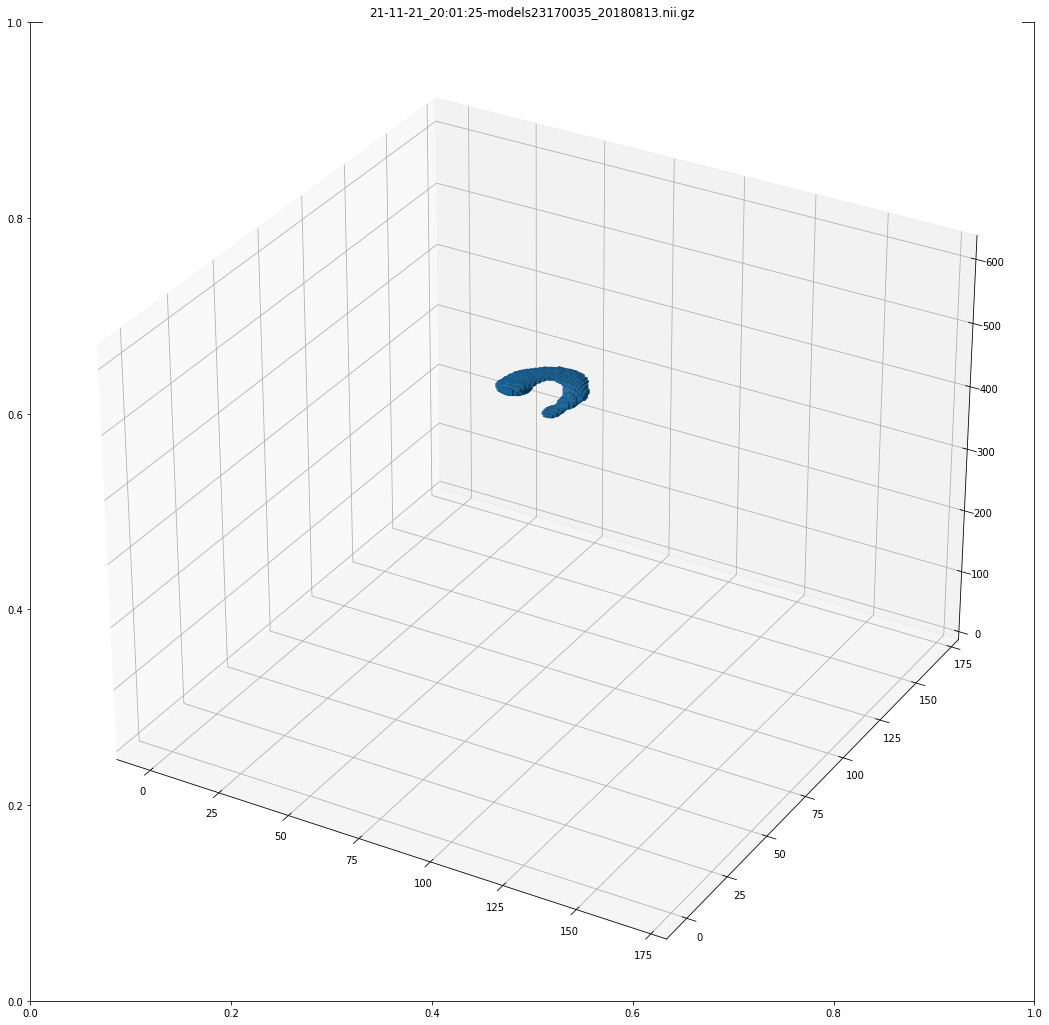

In [44]:
view_3d(36)

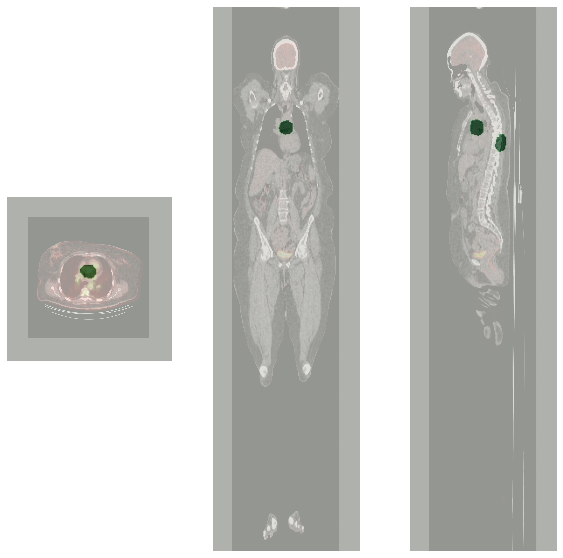

In [6]:
check_petctroi(ptarr,ctarr,pred_arr)

In [2]:
def progress_view(Model_,Net_,Trainer_,Fold_):
    adr = '/tf/submission/submitted/{}/nnUNet/{}/Task550_PETCT/{}/{}/progress.png'.format(Model_,Net_,Trainer_,Fold_)
    img = mpimg.imread(adr)
    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.show()

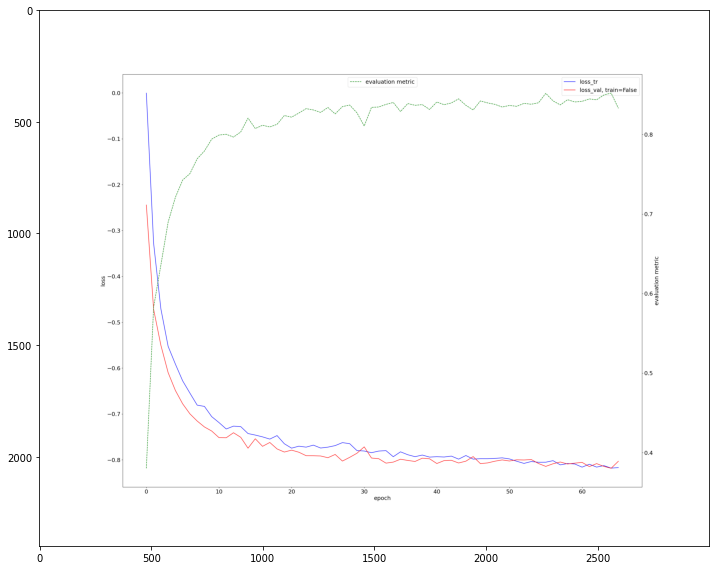

In [18]:
adr = '/tf/backup/working/nnUNet/nnunet/nnUNet_trained_models/nnUNet/3d_fullres/Task572_PETCT/nnUNetTrainerV2_Loss_DiceTopK10__nnUNetPlansv2.1/fold_4/progress.png'
img = mpimg.imread(adr)
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.show()

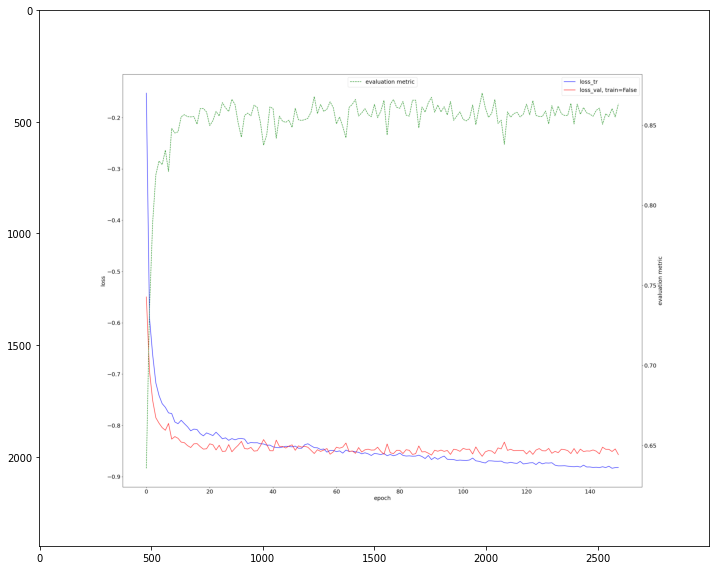

In [270]:
progress_view('21-11-12_15:39:15-models','3d_fullres','nnUNetTrainerV2__nnUNetPlansv2.1','fold_0')


In [61]:
predarr1 = np.array(nib.load(PN_list_path[1]).dataobj)
# [predarr0, predarr1]

In [15]:
pred_arr = np.array(nib.load(PN_list_path[1]).dataobj)
ptarr,ctarr,pred_arr

print(ptarr.shape)
print(ctarr.shape)
print(pred_arr.shape)

(128, 128, 335)
(128, 128, 335)
(128, 128, 335)


In [3]:
PN_list_path

NameError: name 'PN_list_path' is not defined

In [43]:
predarr0 = np.array(nib.load(PN_list_path[38]).dataobj)
predarr1 = np.array(nib.load(PN_list_path[39]).dataobj)
print(predarr0.shape, predarr1.shape)

(192, 192, 335) (192, 192, 335)


2284

In [21]:
pp = p0 + p1

In [59]:
predarr0 = np.array(nib.load(PN_list_path[0]).dataobj)
print('{} :'.format(PN_list_path[0]), predarr0.shape)

/tf/submission/submitted/21-11-21_20:01:25-models/result/23010031_20140423.nii.gz : (200, 200, 326)


/tf/submission/submitted/21-11-22_23:41:56-models/result/23170035_20180813.nii.gz : (168, 168, 624)


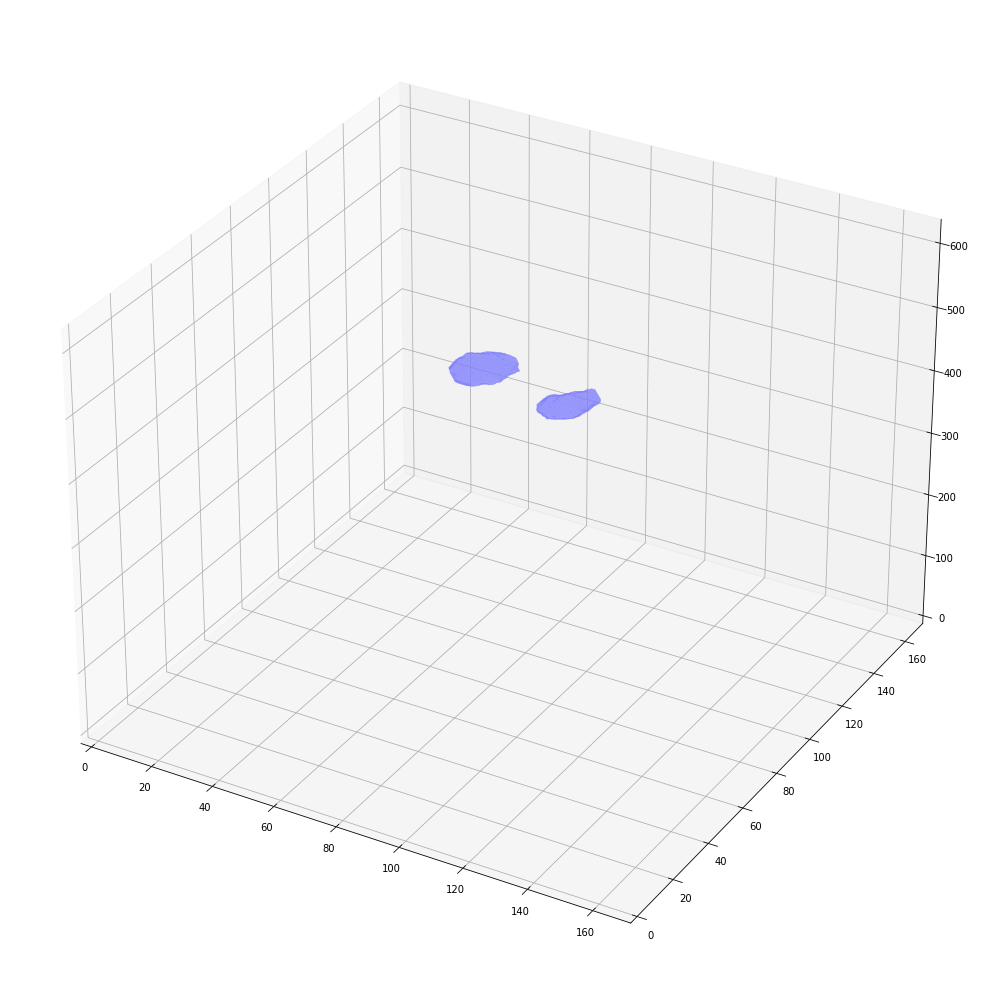

In [10]:


from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

NUM = 36
predarr0 = np.array(nib.load(PN_list_path[NUM]).dataobj)
print('{} :'.format(PN_list_path[NUM]), predarr0.shape)

p0 = predarr0.transpose(0,1,2)

verts1, faces1, normals, values = measure.marching_cubes(p0, 0)


fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')

mesh1 = Poly3DCollection(verts1[faces1], cmap="hot", alpha=0.6)

face_color = [0.5, 0.5, 1]
# mesh0.set_facecolor('#FF0000') #FF0000
# mesh1.set_facecolor('#9370DB') #9370DB
mesh1.set_facecolor(face_color)
ax.add_collection3d(mesh1)
# ax.add_collection3d(mesh1)

ax.set_xlim(0, p0.shape[0])
ax.set_ylim(0, p0.shape[1])
ax.set_zlim(0, p0.shape[2])

plt.show()
# np.unique(ctarr)

In [6]:
import h5py
import os
datalist = os.listdir('/mnt/dataset')

for hdf5_file in datalist:
    
    hdf5_path = os.path.join('/mnt/dataset/', hdf5_file)
    
    # image
    f_i = h5py.File(hdf5_path, 'r')
    ctarr = np.asarray(f_i['CT'])
    petarr = np.asarray(f_i['PET'])
    labels = np.asarray(f_i['Aorta'])
    sizearr = np.asarray(f_i['Size'])
    f_i.close()
    
    print('{} :'.format(hdf5_file), ctarr.shape, petarr.shape, labels.shape)

23090580_20131226.hdf5 : (128, 128, 335) (128, 128, 335) (128, 128, 335)
23090618_20161212.hdf5 : (128, 128, 335) (128, 128, 335) (128, 128, 335)
23090628_20150204.hdf5 : (128, 128, 299) (128, 128, 299) (128, 128, 299)
23010011_20150408.hdf5 : (200, 200, 284) (200, 200, 284) (200, 200, 284)
23090643_20121227.hdf5 : (128, 128, 335) (128, 128, 335) (128, 128, 335)
23090644_20131216.hdf5 : (128, 128, 335) (128, 128, 335) (128, 128, 335)
23090636_20121018.hdf5 : (128, 128, 299) (128, 128, 299) (128, 128, 299)
23090585_20130213.hdf5 : (128, 128, 335) (128, 128, 335) (128, 128, 335)
23010010_20150805.hdf5 : (200, 200, 326) (200, 200, 326) (200, 200, 326)
23170007_20190507.hdf5 : (192, 192, 335) (192, 192, 335) (192, 192, 335)
23090572_20130226.hdf5 : (128, 128, 335) (128, 128, 335) (128, 128, 335)
23010050_20130704.hdf5 : (200, 200, 326) (200, 200, 326) (200, 200, 326)
23010020_20141219.hdf5 : (200, 200, 326) (200, 200, 326) (200, 200, 326)
23010021_20141128.hdf5 : (200, 200, 284) (200, 200,